In [54]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
import sys

sys.path.insert(
    0,
    r"C:\Users\Asus\Desktop\Repo\MasterThesis_RI\Python-Real-World-Machine-Learning\Module 2\Chapter 5",
)

import warnings

warnings.filterwarnings("ignore")

# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sampling
from modAL.uncertainty import uncertainty_sampling
from modAL.density import information_density

# Modelling
# Classification
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.svm import SVC

# Semi-Supervised Learning
from sklearn.semi_supervised import (
    LabelPropagation,
    LabelSpreading,
    SelfTrainingClassifier,
)
from modAL.models import ActiveLearner

# Chapter 5
from SelfLearning import SelfLearningModel
from scikitWQDA import WQDA

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
    ConfusionMatrixDisplay,
    log_loss,
)

# Ensembling
from sklearn.ensemble import *

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Binning
import woeBinningPandas

# Create Unique ID
import uuid

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Preprocessing

First, basic data preprocessing to obtain accepted and rejected training and test samples separately. Save rejected data in two versions: with and without lables. The rejected data without labels is needed for the semi-supervised model. The rejected data without labels is needed to perform evaluation. <br>
*Note for improvement: artificial id is currently generated as unique key to be used in merging. We can merge on index instead. Drop for future.*

In [56]:
def data_preprocessing(df, accepted_flag, target, train_ratio):
    """
    The goal of this function is to load the original dataset, split it into accepts and rejects,
    add ids, which can later be used for merging. For the rejects to further perform train / test split

    Parameters
    ----------

    df : name of the original dataset in quotation marks, csv format
    accepted_flag: name of the accepted flag; Binary: 1 if accepted, 0 if rejected
    target : name of the target column
    train_ratio : percentage used for training; Continuous (0,1)

    Return
    ------
    a : accepted data
    r : rejected data
    r_dev : rejected trainining data without label
    r_test : rejected testing data without label
    dfr_dev_with_label: rejected training data with label
    dft_test_with_label: rejected training data with label

    """
    # Load data
    data = pd.read_csv("C:/Users/Asus/Desktop/Repo/MasterThesis_RI/Data_09_05/" + df)

    # Accepted

    ## Create separate dataset with accepts
    dfa = data[data[accepted_flag] == 1]
    dfa = dfa.drop([accepted_flag], axis=1)
    ## Rename target variable as "target"
    dfa = dfa.rename(columns={target: "target"})
    ## Add id to the dataset, which can later be used for merging
    dfa["id"] = dfa.index.to_series().map(lambda x: uuid.uuid4())

    # Rejected

    ## Create separate dataset with accepts
    dfr = data[data[accepted_flag] == 0]
    dfr = dfr.drop([accepted_flag], axis=1)
    ## Add id to the dataset, which can later be used for merging
    dfr["id"] = dfr.index.to_series().map(lambda x: uuid.uuid4())
    ## Train/Test Split (without labels)
    ### Shuffle the dataset
    shuffle_df = dfr.sample(frac=1, random_state=42)
    ### Define a size for the train set
    train_size = int(train_ratio * len(shuffle_df))
    ### Split the dataset
    dfr_dev = shuffle_df[:train_size]
    dfr_test = shuffle_df[train_size:]
    ## Save a copy of the rejected data with label
    dfr_dev_with_label = dfr_dev
    dfr_test_with_label = dfr_test
    ## Unlabel the rejects (i.e. drop the target) and save a copy of the rejeted data without label
    dfr_dev2 = dfr_dev_with_label.drop([target], axis=1)
    dfr_test2 = dfr_test_with_label.drop([target], axis=1)

    return dfr_dev_with_label, dfr_test_with_label, dfa, dfr, dfr_dev2, dfr_test2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
dfr_dev_with_label, dfr_test_with_label, a, r, r_dev, r_test = data_preprocessing(
    "paper_1.csv", "is_accepted", "y", 0.8
)

<IPython.core.display.Javascript object>

In [5]:
print(a.shape)  # accepted
print(r.shape)  # rejected
print(r_dev.shape)  # rejected train
print(r_test.shape)  # rejected test

(14000, 11)
(6000, 11)
(4800, 10)
(1200, 10)


<IPython.core.display.Javascript object>

The below two functions are used to store versions of the reject dataset with and without id. Data without id used for modelling, data with id used for merging. To be dropped in future.

In [67]:
def select_columns_rejects_without_id(r_dev, r_test, r_dev_mod, r_test_mod):
    """
    The goal of this function is to create rejects datasets (train and test) with the modelling columns only.
    Currently hard-coded to work for a dataset with 8 features.

    Parameters
    ----------

    r_dev: rejects training data; Dataframe
    r_test: rejects testing data; Dataframe
    r_dev_mod: name of the rejecs training data without id; String
    r_test_mod: name of the rejects training data without id

    Return
    ------
    r_dev_mod: rejecs training data without id; Dataframe
    r_test_mod: rejects training data without id; Dataframe

    """

    r_dev_mod = r_dev.iloc[:, :9]
    r_test_mod = r_test.iloc[:, :9]
    return r_dev_mod, r_test_mod

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
def select_columns_rejects_with_id(r_dev, r_test, r_dev_mod_id, r_test_mod_id):
    """
    The goal of this function is to Create rejects datasets with the modelling columns + id
    Currently hard-coded to work for a dataset with 8 features.

    Parameters
    ----------

    r_dev: rejects training data; Dataframe
    r_test: rejects testing data; Dataframe
    r_dev_mod_id: rejecs training data with id; name of the rejecs training data with id; String
    r_test_mod_id: rejects training data with id; name of the rejecs training data with id; String

    Return
    ------
    r_dev_mod_id: rejecs training data with id; Dataframe
    r_test_mod_id: rejects training data with id; Dataframe

    """
    r_dev_mod_id = r_dev.iloc[:, :10]
    r_test_mod_id = r_test.iloc[:, :10]
    return r_dev_mod_id, r_test_mod_id

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
r_dev_mod, r_test_mod = select_columns_rejects_without_id(
    r_dev, r_test, "r_dev_mod", "r_test_mod"
)
r_dev_mod_id, r_test_mod_id = select_columns_rejects_with_id(
    r_dev, r_test, "r_dev_mod_id", "r_test_mod_id"
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The below two functions continue the data preprocessing. Used to create feature and target data and to split into train and test samples.

In [70]:
def create_X_y(data):
    """
    Undersample the data

    Parameters
    ----------
    data : Dataframe

    Return
    ------
    X_res : undersampled data; Dataframe
    y_res : undersampled labels; Dataframe

    """
    # Create X and y
    X = data.loc[:, data.columns != "target"]
    y = data.loc[:, data.columns == "target"]

    return X, y

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
def split(X, y):
    """
    Split the data into training and testing sample

    Parameters
    ----------
    X : data
    y : labels

    Return
    ------
    X_train : training modelling fields
    X_test : test modelling fields
    y_train : training labels
    y_test : testing labels

    """
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=7
    )
    columns = X_train.columns

    # Columns
    X_train = pd.DataFrame(data=X_train, columns=columns)
    y_train = pd.DataFrame(data=y_train, columns=["target"])

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
X_res, y_res = create_X_y(a)
X_train, X_test, y_train, y_test = split(X_res, y_res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
n = int(0.1 * (len(X_train)))
X_train = X_train[:n]
y_train = y_train[:n]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelling

First, we select the features that will end up in the model. The selection of columns below is subject to iteration based on the modelling outcomes from the logistic regression, i.e. significance (p-values).

In [74]:
significant_columns = [
    "known_col_0",
    "known_col_1",
    "known_col_3",
    "known_col_4",
]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The below rows keep only significant columns (or target) in the respective datasets

In [75]:
# Primary datasets
X_train = X_train[significant_columns]
X_test_3 = X_test[significant_columns]
r_dev_mod = r_dev_mod[significant_columns]
r_test_mod = r_test_mod[significant_columns]
# Rejects with labels
dfr_dev_with_label.rename(columns={"y": "target"}, inplace=True)
dfr_dev_with_label_X = dfr_dev_with_label[significant_columns]
dfr_dev_with_label_y = dfr_dev_with_label[["target"]]
dfr_test_with_label.rename(columns={"y": "target"}, inplace=True)
dfr_test_with_label_X = dfr_test_with_label[significant_columns]
dfr_test_with_label_y = dfr_test_with_label[["target"]]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Modelling

### Base Model

We build the same regression twice with different libraries. statmodels is used to show easier the p-values.

In [76]:
# Build Logistic regression
# Statmodels
X_in = sm.add_constant(X_train.astype(float))
logit_model = sm.Logit(y_train, X_in)
result3 = logit_model.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.116354
         Iterations 10
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.823      
Dependent Variable: target           AIC:              270.6336   
Date:               2021-05-18 09:14 BIC:              295.7390   
No. Observations:   1120             Log-Likelihood:   -130.32    
Df Model:           4                LL-Null:          -735.65    
Df Residuals:       1115             LLR p-value:      7.7481e-261
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const          -2.1415    0.2496  -8.5785  0.0000  -2.6308  -1.6522
known_col_0    -1.7719    0.2048  -8.6532  0.000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
def log_reg(X_train, y_train, X_test):
    # logreg = LogisticRegression(fit_intercept=False, penalty="none")
    # logreg = RandomForestClassifier()
    logreg = LGBMClassifier()
    logreg.fit(X_train, y_train.values.ravel())
    y_pred = logreg.predict(X_test)
    return logreg, y_pred

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
logreg, y_pred = log_reg(X_train, y_train, X_test_3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy score Logistic Regression: 0.9246428571428571


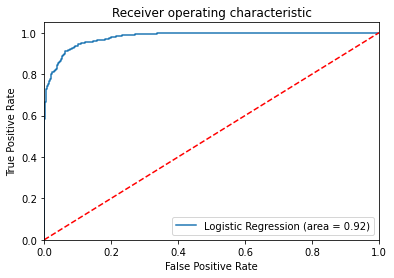

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
# Plot
print("Accuracy score Logistic Regression:", logreg.score(X_test_3, y_test))
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_3))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_3)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

The default rate and conservative default rate are used for future cut-off calculation.

In [80]:
dr = len(y_test[y_test["target"] == 1]) / (
    len(y_test[y_test["target"] == 1]) + len(y_test[y_test["target"] == 0])
)
conservative_dr = (
    1.1
    * len(y_test[y_test["target"] == 1])
    / (len(y_test[y_test["target"] == 1]) + len(y_test[y_test["target"] == 0]))
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Isolation Forest

For rejects, another step of data preporcessing is applied via Isolation Forest model. The goal is to remove outliers. The isolation forest is trained on all accepts and is used to evaluate the similarity of the rejects. Then the rejects that are found to be the most and least similar to the accepts are dropped. The contaimination parameter determines how many observations are excluded.

In [81]:
def isolation_forest(X_train, r_dev_mod, r_test_mod):
    """
    The goal of this function is to filter the outliers from the rejected sample.

    Parameters
    ----------
    X_train: accepts training data; Dataframe
    r_dev_mod: rejects modelling data prior outlier treatment; Dataframe
    r_test_mod: rejects testinf data prior outlier treatment; Dataframe

    Return
    ------
    r_dev_mod: rejects modelling data post outlier treatment; Dataframe
    r_test_mod: rejects training data prior outlier treatment; Dataframe

    """

    # Build Isolation forest model
    isf = IsolationForest(
        n_estimators=50, max_samples="auto", contamination=float(0.02), max_features=1.0
    )
    isf.fit(X_train)
    rej_isf = isf.predict(r_dev_mod)
    # Add scores and anomaly columns to rejected train
    r_dev_mod["scores"] = isf.decision_function(r_dev_mod)
    r_dev_mod["anomaly"] = isf.predict(
        r_dev_mod[["known_col_0", "known_col_1", "known_col_3", "known_col_4"]]
    )
    # Print number of non-outliers and outliers
    print(
        "Rejected Train. Number of non-outliers is:", np.sum(r_dev_mod["anomaly"] == 1)
    )
    print("Rejected Train. Number of outliers is:", np.sum(r_dev_mod["anomaly"] == -1))
    # Drop all outliers
    r_dev_mod = r_dev_mod[r_dev_mod.anomaly != -1]
    # Delete columns related to the outliers
    r_dev_mod = r_dev_mod[["known_col_0", "known_col_1", "known_col_3", "known_col_4"]]

    # Add scores and anomaly columns to rejected test
    r_test_mod["scores"] = isf.decision_function(r_test_mod)
    r_test_mod["anomaly"] = isf.predict(
        r_test_mod[["known_col_0", "known_col_1", "known_col_3", "known_col_4"]]
    )
    # Print number of non-outliers and outliers
    print(
        "Rejected Test. Number of non-outliers is:", np.sum(r_test_mod["anomaly"] == 1)
    )
    print("Rejected Test. Number of outliers is:", np.sum(r_test_mod["anomaly"] == -1))
    # Drop all outliers
    r_test_mod = r_test_mod[r_test_mod.anomaly != -1]
    # Delete columns related to the outliers
    r_test_mod = r_test_mod[
        ["known_col_0", "known_col_1", "known_col_3", "known_col_4"]
    ]

    return r_dev_mod, r_test_mod

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
# r_dev_mod, r_test_mod = isolation_forest(X_train, r_dev_mod, r_test_mod)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predictions

In [83]:
def pred(y_test, X_test, X_test_3, model):
    # Test set with labels
    test_labels = pd.merge(
        y_test,
        X_test,
        how="inner",
        left_index=True,
        right_index=True,
    )
    # Predictions on testset
    test_pred = model.predict_proba(X_test_3)[:, 1]
    test_pred2 = pd.DataFrame(data=test_pred, columns=["prediction"])
    test_pred2["count"] = test_pred2.groupby("prediction")["prediction"].transform(
        "count"
    )
    test_pred2.groupby(["prediction"]).count()
    test_pred2.describe()

    # Join predictions with test new
    pred_test_kgb = pd.DataFrame(
        data=test_pred, columns=["prediction_beforeRI"], index=y_test.index.copy()
    )
    pred_test1 = pd.merge(
        test_labels,
        pred_test_kgb[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )

    return pred_test1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
# Predictions on Accepted Test Sample
pred_test1 = pred(y_test, X_test, X_test_3, logreg)
# Predictions on Rejected Test Sample
pred_dev_rej = pred(
    dfr_dev_with_label_y, dfr_dev_with_label, dfr_dev_with_label_X, logreg
)
pred_test_rej = pred(
    dfr_test_with_label_y, dfr_test_with_label, dfr_test_with_label_X, logreg
)
pred_rej1 = pred(
    dfr_test_with_label_y, dfr_test_with_label, dfr_test_with_label_X, logreg
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
# Prediction before RI
ri1_train_rej = pred_dev_rej[["target_x", "id", "prediction_beforeRI"]]
ri1_train_rej["prediction_beforeRI"] = ri1_train_rej["prediction_beforeRI"].apply(
    lambda x: 0
    if (x < ri1_train_rej["prediction_beforeRI"].quantile(q=1 - conservative_dr))
    else 1
)
ri1_test_rej = pred_test_rej[["target_x", "id", "prediction_beforeRI"]]
ri1_test_rej["prediction_beforeRI"] = ri1_test_rej["prediction_beforeRI"].apply(
    lambda x: 0
    if (x < ri1_test_rej["prediction_beforeRI"].quantile(q=1 - conservative_dr))
    else 1
)
pred_rej1 = pred_rej1[["target_x", "id", "prediction_beforeRI"]]
pred_rej1["prediction_beforeRI"] = pred_rej1["prediction_beforeRI"].apply(
    lambda x: 0
    if (x < pred_rej1["prediction_beforeRI"].quantile(q=1 - conservative_dr))
    else 1
)
ri1_train_rej.rename(columns={"target_x": "target"}, inplace=True)
ri1_test_rej.rename(columns={"target_x": "target"}, inplace=True)
pred_rej1.rename(columns={"target_x": "target"}, inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predictions (Labelling Rejects)

In [86]:
def predictions1(model):
    # Join predictions with train new
    pred = model.predict_proba(r_dev_mod)[:, 1]
    pred2 = pd.DataFrame(
        data=pred,
        columns=["prediction2"],
        index=r_dev_mod.index.copy(),
    )

    # Set cut-off
    q1 = pred2["prediction2"].quantile(q=1 - conservative_dr)
    pred2["prediction_beforeRI"] = pred2["prediction2"].apply(
        lambda x: 0 if (x < q1) else 1
    )
    outcome = pd.merge(
        r_dev_mod_id,
        pred2[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    outcome = outcome[["id", "prediction_beforeRI"]]
    return outcome

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Predictions

In [87]:
ri1_train = predictions1(logreg)  # Logistic Regression

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Basic Evaluation Measures

In [88]:
def print_results(data, state, prediction):
    print(
        "The number of accurately classified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 1)
            | (data.target == 0) & (data[prediction] == 0)
        ].shape[0],
    )
    print(
        "The number of misclassified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 0)
            | (data.target == 0) & (data[prediction] == 1)
        ].shape[0],
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [89]:
def log_loss_fun(
    category,
    data,
    y_true,
    y_pred,
):
    print(category, " :", log_loss(data[y_true], data[y_pred]))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
def all_metrics(pred_label, true_label, model):
    """""
    pred_label = predicted label of the model
    true_label = true label
    model = model name
    """ ""

    # F1 score
    f1_stat = f1_score(pred_label, true_label, average="weighted")

    # Confusion matrix
    cm = confusion_matrix(pred_label, true_label, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    fig = disp.plot()

    return print("F1_stat ", model, "is: ", f1_stat, fig)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
def evaluation(ri_data):  # ri1_train, ri2_train, etc..

    # TRAIN NEW
    # Join labels to train set
    # Accepts
    train_accepts = pd.merge(
        X_train,
        y_train[["target"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    train_accepts["Flag1"] = "Accept"

    # Rejects
    train_rejects = pd.merge(
        r_dev_mod,
        ri_data[["prediction_beforeRI"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    # Align naming
    train_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)

    # Create X and y
    X_res_rej, y_res_rej = create_X_y(train_rejects)

    #     # Sample a matching number of observations from the accepts as the size of rejects
    #     # Shuffle the dataset
    #     shuffle_df = train_accepts.sample(frac=1, random_state=42)
    #     # Define a size for the train set
    #     train_size = int(0.25 * len(shuffle_df))
    #     train_accepts = shuffle_df[:train_size]
    #     print(train_accepts.shape)

    # Concatenate Train Accepts and Train Rejects
    train_new = pd.concat([train_accepts, train_rejects])

    # Flag
    train_new["Flag"] = train_new["Flag1"].apply(
        lambda x: "Accept" if x == "Accept" else "Reject"
    )
    train_new = train_new.drop(columns=["Flag1"])

    # Retrain KGB Model

    # Split
    X_new = train_new[significant_columns]
    y_new = train_new["target"]
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_new, y_new, test_size=0.2, random_state=42
    )

    # Keep only columns for modelling
    os_data_X_2_new = X_train_new[significant_columns]
    X_test_2_new = X_test_new[significant_columns]

    # Build Logistic regression
    # logreg2 = LogisticRegression(fit_intercept=False, penalty="none")
    # logreg2 = GradientBoostingClassifier(criterion="mse")
    # logreg2 = RandomForestClassifier()
    logreg2 = LGBMClassifier()
    logreg2.fit(os_data_X_2_new, y_train_new.values.ravel())

    # Predictions
    pred_test2 = pred(y_test, X_test, X_test_3, logreg2)
    pred_test2.rename(
        columns={"prediction_beforeRI": "prediction_baseline"}, inplace=True
    )

    # Merge original and baseline predictions
    pred_test_final = pd.merge(
        pred_test1[["target", "prediction_beforeRI"]],
        pred_test2[["prediction_baseline"]],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # Make binary predictions based on cutoff 50percentile of the distribution
    q1 = pred_test_final["prediction_beforeRI"].quantile(q=1 - conservative_dr)
    q2 = pred_test_final["prediction_baseline"].quantile(q=1 - conservative_dr)
    #     print(q1)
    #     print(q2)
    pred_test_final["prediction_beforeRI_binary"] = pred_test_final[
        "prediction_beforeRI"
    ].apply(lambda x: 0 if (x < q1) else 1)
    pred_test_final["prediction_baseline"] = pred_test_final[
        "prediction_baseline"
    ].apply(lambda x: 0 if (x < q2) else 1)

    #     # Log Loss
    #     log_loss_fun("Before", pred_test_final, "target", "prediction_beforeRI_binary")
    #     log_loss_fun("After", pred_test_final, "target", "prediction_baseline")

    #     # Numbers of accurately classified and misclassified cases
    #     print_results(pred_test_final, "before RI", "prediction_beforeRI_binary")
    #     print_results(pred_test_final, "with baseline", "prediction_baseline")
    return pred_test_final

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**NOTE: The higher the DR the lower the quantile**

In [92]:
def evaluation_rejects(ri_data):  # ri1_train, ri2_train, etc..

    # TRAIN NEW
    # Join labels to train set
    # Accepts
    train_accepts = pd.merge(
        X_train,
        y_train[["target"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    train_accepts["Flag1"] = "Accept"

    # Rejects
    train_rejects = pd.merge(
        r_dev_mod,
        ri_data[["prediction_beforeRI"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    # Align naming
    train_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)

    # Create X and y for rejects
    X_res_rej, y_res_rej = create_X_y(train_rejects)

    #     # Sample a matching number of observations from the accepts as the size of rejetcs
    #     ## Shuffle the dataset
    #     shuffle_df = train_accepts.sample(frac=1, random_state=42)
    #     ## Define a size for the train set
    #     train_size = int(0.03 * len(shuffle_df))
    #     train_accepts = shuffle_df[:train_size]
    #     print(train_accepts.shape)

    # Concatenate Train Accepts and Train Rejects
    train_new = pd.concat([train_accepts, train_rejects])

    # Flag
    train_new["Flag"] = train_new["Flag1"].apply(
        lambda x: "Accept" if x == "Accept" else "Reject"
    )
    train_new = train_new.drop(columns=["Flag1"])

    # Retrain KGB Model

    # Split
    X_new = train_new[significant_columns]
    y_new = train_new["target"]
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_new, y_new, test_size=0.2, random_state=42
    )

    # Keep only columns for modelling
    os_data_X_2_new = X_train_new[significant_columns]
    X_test_2_new = X_test_new[significant_columns]

    # Build Logistic regression
    # logreg2 = LogisticRegression(fit_intercept=False, penalty="none")
    # logreg2 = GradientBoostingClassifier(criterion="mse")
    # logreg2 = RandomForestClassifier()
    logreg2 = LGBMClassifier()
    logreg2.fit(os_data_X_2_new, y_train_new.values.ravel())

    # Predictions
    pred_rej2 = pred(
        dfr_test_with_label_y, dfr_test_with_label_X, dfr_test_with_label_X, logreg2
    )
    pred_rej2.rename(
        columns={"prediction_beforeRI": "prediction_baseline"}, inplace=True
    )

    # Merge original and baseline predictions
    pred_test_final = pd.merge(
        pred_rej1[["target", "prediction_beforeRI"]],
        pred_rej2[["prediction_baseline"]],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # Make binary predictions based on cutoff: median of the distribution
    q1 = pred_test_final["prediction_beforeRI"].quantile(q=1 - conservative_dr)
    q2 = pred_test_final["prediction_baseline"].quantile(q=1 - conservative_dr)
    #     print(q1)
    #     print(q2)
    pred_test_final["prediction_beforeRI_binary"] = pred_test_final[
        "prediction_beforeRI"
    ].apply(lambda x: 0 if (x < q1) else 1)
    pred_test_final["prediction_baseline"] = pred_test_final[
        "prediction_baseline"
    ].apply(lambda x: 0 if (x < q2) else 1)

    #     # Log Loss
    #     log_loss_fun("Before", pred_test_final, "target", "prediction_beforeRI_binary")
    #     log_loss_fun("After", pred_test_final, "target", "prediction_baseline")

    #     # Numbers of accurately classified and misclassified cases
    #     print_results(pred_test_final, "before RI", "prediction_beforeRI_binary")
    #     print_results(pred_test_final, "with baseline", "prediction_baseline")
    return pred_test_final

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Kickout Evaluation

In [112]:
def flag_df(df):

    # Flag kicked out bad cases (want more of these)
    if (
        df["target"] == 1
        and df["prediction_beforeRI_binary"] == 0
        and df["prediction_baseline"] == 1
    ):
        return "KB"

    # Flag kicked out good cases (want less of these)
    elif (
        df["target"] == 0
        and df["prediction_beforeRI_binary"] == 0
        and df["prediction_baseline"] == 1
    ):
        return "KG"

    # Flag kicked in good cases (want more of these)
    elif (
        df["target"] == 0
        and df["prediction_beforeRI_binary"] == 1
        and df["prediction_baseline"] == 0
    ):
        return "IG"

    # Flag kicked in bad cases (want less of these)
    elif (
        df["target"] == 1
        and df["prediction_beforeRI_binary"] == 1
        and df["prediction_baseline"] == 0
    ):
        return "IB"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [113]:
def kickout(df):

    # Counts of kickout bad and kickout good
    counts = df["Flag"].value_counts()
    if "KB" in df.values:
        kb = counts.KB  # want more of these
    else:
        kb = 0
    if "KG" in df.values:
        kg = counts.KG  # want less of these
    else:
        kg = 0

    if "IG" in df.values:
        ig = counts.IG  # want more of these
    else:
        ig = 0

    if "IB" in df.values:
        ib = counts.IB  # want less of these
    else:
        ib = 0

    # Counts of number of actual bad cases
    sb = df[df["target"] == 1].shape[0]
    sg = df[df["target"] == 0].shape[0]

    # Target
    counts_target = df["target"].value_counts()
    total_bads = counts_target[0]
    total_goods = counts_target[1]

    total_bads = df[df["target"] == 1].shape[0]
    total_goods = df[df["target"] == 0].shape[0]
    pb = total_bads / (total_bads + total_goods)
    pg = total_goods / (total_bads + total_goods)

    # Calculate kickout metric
    kickout = (((kb / pb) - (kg / (1 - pb))) / sb) * (pb * pb)
    kickin = (((ig / pg) - (ib / (1 - pg))) / sg) * (pg * pg)
    weighted_total = kickout + kickin

    return (
        print(
            "Kickout + Kickin Metric:",
            round(weighted_total, 3),
        ),
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [114]:
def flag_df_beforeRI(df):

    # Flag kicked out bad cases (want more of these)
    if df["target"] == 1 and df["prediction_beforeRI_binary"] == 1:
        return "CB"

    # Flag kicked out good cases (want less of these)
    elif df["target"] == 1 and df["prediction_beforeRI_binary"] == 0:
        return "IB"

    # Flag kicked in good cases (want more of these)
    elif df["target"] == 0 and df["prediction_beforeRI_binary"] == 0:
        return "CG"

    # Flag kicked in bad cases (want less of these)
    elif df["target"] == 0 and df["prediction_beforeRI_binary"] == 1:
        return "IG"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
def kickout_beforeRI(df):

    # Counts of kickout bad and kickout good
    counts = df["Flag"].value_counts()
    if "CB" in df.values:
        cb = counts.CB  # want more of these
    else:
        cb = 0
    if "IB" in df.values:
        ib = counts.IB  # want less of these
    else:
        ib = 0

    if "CG" in df.values:
        cg = counts.CG  # want more of these
    else:
        cg = 0

    if "IG" in df.values:
        ig = counts.IG  # want less of these
    else:
        ig = 0

    # Target
    total_bads = df[df["target"] == 1].shape[0]
    total_goods = df[df["target"] == 0].shape[0]
    pb = total_bads / (total_bads + total_goods)
    pg = total_goods / (total_bads + total_goods)

    kickout = (((cb / pb) - (ib / pb)) / total_bads) * (pb ** 2)
    kickin = (((cg / pg) - (ig / pg)) / total_goods) * (pg ** 2)
    weighted_total = kickout + kickin
    return print(
        "Kickout + Kickin Metric:",
        round(weighted_total, 3),
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [116]:
def flag_df_baseline(df):

    # Flag kicked out bad cases (want more of these)
    if df["target"] == 1 and df["prediction_baseline"] == 1:
        return "CB"

    # Flag kicked out good cases (want less of these)
    elif df["target"] == 1 and df["prediction_baseline"] == 0:
        return "IB"

    # Flag kicked in good cases (want more of these)
    elif df["target"] == 0 and df["prediction_baseline"] == 0:
        return "CG"

    # Flag kicked in bad cases (want less of these)
    elif df["target"] == 0 and df["prediction_baseline"] == 1:
        return "IG"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [117]:
def kickout_baseline(df):

    # Counts of kickout bad and kickout good
    counts = df["Flag"].value_counts()
    if "CB" in df.values:
        cb = counts.CB  # want more of these
    else:
        cb = 0
    if "IB" in df.values:
        ib = counts.IB  # want less of these
    else:
        ib = 0

    if "CG" in df.values:
        cg = counts.CG  # want more of these
    else:
        cg = 0

    if "IG" in df.values:
        ig = counts.IG  # want less of these
    else:
        ig = 0

    # Target
    total_bads = df[df["target"] == 1].shape[0]
    total_goods = df[df["target"] == 0].shape[0]
    pb = total_bads / (total_bads + total_goods)
    pg = total_goods / (total_bads + total_goods)

    kickout = (((cb / pb) - (ib / pb)) / total_bads) * (pb ** 2)
    kickin = (((cg / pg) - (ig / pg)) / total_goods) * (pg ** 2)
    weighted_total = kickout + kickin
    return print(
        "Kickout + Kickin Metric:",
        round(weighted_total, 3),
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [118]:
outcome_a = evaluation(ri1_train)  # Simple Augmentation - Log Reg

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [119]:
outcome_a["Flag"] = outcome_a.apply(flag_df_beforeRI, axis=1)
kickout_beforeRI(outcome_a)

Kickout + Kickin Metric: 0.834


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [120]:
outcome_a["Flag"] = outcome_a.apply(flag_df_baseline, axis=1)
kickout_baseline(outcome_a)

Kickout + Kickin Metric: 0.825


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [121]:
outcome_b = evaluation_rejects(ri1_train_rej)  # Simple Augmentation - Log Reg

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [122]:
outcome_b["Flag"] = outcome_b.apply(flag_df_beforeRI, axis=1)
kickout_beforeRI(outcome_b)

Kickout + Kickin Metric: 0.735


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [123]:
outcome_b["Flag"] = outcome_b.apply(flag_df_baseline, axis=1)
kickout_baseline(outcome_b)

Kickout + Kickin Metric: 0.745


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Semi-Supervised Learning

Based on existing literature semi-supervised learning is chosen for RI. The method is suitable for the problem because the labels of the accepted population (good/bad) are known and the labels of the rejected population are unknown. Without ignoring the inherent bias between accepts and rejects, semi-supervised methods use both labelled and unlabelled data during fit. <br> **1. Data preparation:** the goal is to create initial dataframe, which contains the known training data and training labels of the accepts and the known training data of the rejects. The training labels of the rejects are unknown, and are therefore labelled with a default value of -1. <br> **2. Train/Test Split** The resulting dataset is again split into explanatory variables and target in order to fit the model. <br> **3. Fit model:** The semi-supervised model is fit. Three types of models are tested: Self Training, Label Spreading and Label Propagation <br> **4. Predictions:** Predictions are made using the known testing data and testing labels of the accepts and the test lables of the rejects <br> **5. Evaluation:** The results of the model before and after reject inference are compared  

In [124]:
def ssl_prep(X_accept, y_accept, X_reject):
    """
    Parameters
    ----------

    X_train_acc : training data of accepted population
    y_train_acc: training lables of accepted population
    X_train_rej: training data of rejected population

    Return
    ------
    df : data of accepted and rejected population

    """
    # Merge explanatory and target in accepts
    accepts = pd.merge(
        X_accept, y_accept, how="left", left_index=True, right_index=True
    )
    # Create accept flag
    accepts["Flag1"] = "Accept"

    #     # Sample a matching number of observations from the rejects as the size of accepts
    #     ## Shuffle the dataset
    #     shuffle_df = X_reject.sample(frac=1)
    #     ## Define a size for the train set
    #     train_size = int(0.25 * len(shuffle_df))
    #     train_rejects = shuffle_df[:train_size]

    train_rejects = X_reject

    # Merge accepts and rejects
    df = pd.concat([accepts, train_rejects])

    # If accepted use accept label, if rejected use -1 (default value for unlabelled entries) - hard-coded for now
    conditions = [
        (df["Flag1"] == "Accept") & (df["target"] == 1),
        (df["Flag1"] == "Accept") & (df["target"] == 0),
    ]
    choices = [1, 0]

    # New target is called unlabel
    df["unlabel"] = np.select(conditions, choices, -1)

    # Select columns for modelling - hard-coded for now - can be moved outside of the function
    df = df[["known_col_0", "known_col_1", "known_col_3", "known_col_4", "unlabel"]]

    return df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [125]:
def ssl_split(df, target):
    """
    Parameters
    ----------

    df : dataframe of accepted and rejected population, including data and labels
    target: string name of the target column, should be passed in quotation marks (e.g. "target")

    Return
    ------
    X_train: training data of accepted and rejected population, ready to be fed into the semi-supervised model
    y_train: training labels of accepted and rejected population, ready to be fed into the semi-supervised model

    """

    X_train = df.loc[:, df.columns != target]
    y_train = df.loc[:, df.columns == target]
    return X_train, y_train

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [126]:
# def ssl_model_cotraining(X_train, y_train, model):
#     gb = GradientBoostingClassifier()
#     lr = LogisticRegression(fit_intercept=True, penalty="none")
#     model = CTClassifier(gb, lr, random_state=42)
#     ctc = model.fit_predict([X_train.to_list(), X_train.to_list()], y_train.to_numpy)
#     return ctc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [127]:
def ssl_model_selftraining(X_train, y_train, model):
    """
    Parameters
    ----------

    X_train : training data of accepted and rejected population
    y_train : training lables of accepted population (0,1) and rejected population (-1)
    model : semi-supervised learning model from sklearn (Self-Training Classifier)

    Return
    ------

    ssl: trained semi-supervised learning model

    """

    # Fit SSL moodel
    # base = RandomForestClassifier()
    base = LGBMClassifier()
    # base = GradientBoostingClassifier(criterion="mse")
    # base = LogisticRegression(fit_intercept=True, penalty="none")
    model = model(base)
    labels = np.copy(y_train)
    data = np.copy(X_train)
    ssl = model.fit(data, labels)
    return ssl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [128]:
def ssl_model_label(X_train, y_train, model):
    """
    Parameters
    ----------

    X_train : training data of accepted and rejected population
    y_train : training lables of accepted population (0,1) and rejected population (-1)
    model : semi-supervised learning model from sklearn (Label Propagation, Label Spreading)

    Return
    ------

    ssl: trained semi-supervised learning model

    """

    # Fit SSL moodel
    model = model()
    labels = np.copy(y_train)
    data = np.copy(X_train)
    ssl = model.fit(data, labels)
    return ssl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [129]:
def ssl_predictions_oth(ssl, X_test):
    """
    Parameters
    ----------

    ssl : trained semi-supervised learning model
    X_test : testing data of accepted and rejected population for predictions

    Return
    ------

    Predictions before RI (binary)
    Predictions after RI (binary)

    """
    # Make Predictions
    y_pred = ssl.predict_proba(X_test)[:, 1]

    # Convert y_pred array to pandas dataframe
    pred_test = pd.DataFrame(
        data=y_pred,
        columns=["prediction_ssl_cont"],
        index=X_test.index.copy(),
    )

    # Set quantile
    q = pred_test["prediction_ssl_cont"].quantile(q=1 - conservative_dr)
    pred_test["prediction_ssl"] = pred_test["prediction_ssl_cont"].apply(
        lambda x: 0 if (x < q) else 1
    )

    # Merge Baseline and SSL prediction
    pred_test_final2 = pd.merge(
        outcome_a[["target", "prediction_baseline", "prediction_beforeRI_binary"]],
        pred_test[["prediction_ssl"]],
        how="inner",
        left_index=True,
        right_index=True,
    )

    #     # Log Loss
    #     log_loss_fun("Before", pred_test_final2, "target", "prediction_beforeRI_binary")
    #     log_loss_fun("After", pred_test_final2, "target", "prediction_ssl")

    #     # Numbers of accurately classified and misclassified cases
    #     print_results(pred_test_final2, "before RI", "prediction_beforeRI_binary")
    #     print_results(pred_test_final2, "after RI", "prediction_ssl")
    return pred_test_final2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [130]:
def ssl_predictions_oth_rej(ssl, dfr_test_with_label_X):
    """
    Parameters
    ----------

    ssl : trained semi-supervised learning model
    X_test : testing data of accepted and rejected population for predictions

    Return
    ------

    Predictions before RI (binary)
    Predictions after RI (binary)

    """
    # Make Predictions

    y_pred = ssl.predict_proba(dfr_test_with_label_X)[:, 1]

    # Convert y_pred array to pandas dataframe
    pred_test = pd.DataFrame(
        data=y_pred,
        columns=["prediction_ssl_cont"],
        index=dfr_test_with_label_X.index.copy(),
    )

    # Set quantile
    q = pred_test["prediction_ssl_cont"].quantile(q=1 - conservative_dr)
    pred_test["prediction_ssl"] = pred_test["prediction_ssl_cont"].apply(
        lambda x: 0 if (x < q) else 1
    )

    # Merge Baseline and SSL prediction
    pred_test_final2 = pd.merge(
        outcome_b[["target", "prediction_baseline", "prediction_beforeRI_binary"]],
        pred_test[["prediction_ssl"]],
        how="inner",
        left_index=True,
        right_index=True,
    )

    #     # Log Loss
    #     log_loss_fun("Before", pred_test_final2, "target", "prediction_beforeRI_binary")
    #     log_loss_fun("After", pred_test_final2, "target", "prediction_ssl")

    #     # Numbers of accurately classified and misclassified cases
    #     print_results(pred_test_final2, "before RI", "prediction_beforeRI_binary")
    #     print_results(pred_test_final2, "after RI", "prediction_ssl")
    return pred_test_final2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Kickout Measure

In [131]:
def flag_df(df):

    # Flag kicked out bad cases (want more of these)
    if (
        df["target"] == 1
        and df["prediction_beforeRI_binary"] == 0
        and df["prediction_ssl"] == 1
    ):
        return "KB"

    # Flag kicked out good cases (want less of these)
    elif (
        df["target"] == 0
        and df["prediction_beforeRI_binary"] == 0
        and df["prediction_ssl"] == 1
    ):
        return "KG"

    # Flag kicked in good cases (want more of these)
    elif (
        df["target"] == 0
        and df["prediction_beforeRI_binary"] == 1
        and df["prediction_ssl"] == 0
    ):
        return "IG"

    # Flag kicked in bad cases (want less of these)
    elif (
        df["target"] == 1
        and df["prediction_beforeRI_binary"] == 1
        and df["prediction_ssl"] == 0
    ):
        return "IB"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [132]:
def flag_df_ssl(df):

    # Flag kicked out bad cases (want more of these)
    if df["target"] == 1 and df["prediction_ssl"] == 1:
        return "CB"

    # Flag kicked out good cases (want less of these)
    elif df["target"] == 1 and df["prediction_ssl"] == 0:
        return "IB"

    # Flag kicked in good cases (want more of these)
    elif df["target"] == 0 and df["prediction_ssl"] == 0:
        return "CG"

    # Flag kicked in bad cases (want less of these)
    elif df["target"] == 0 and df["prediction_ssl"] == 1:
        return "IG"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [133]:
# def kickout_ssl(df):

#     # Counts of kickout bad and kickout good
#     counts = df["Flag"].value_counts()
#     if "KB" in df.values:
#         kb = counts.KB  # want more of these
#     else:
#         kb = 0
#     if "KG" in df.values:
#         kg = counts.KG  # want less of these
#     else:
#         kg = 0

#     if "IG" in df.values:
#         ig = counts.IG  # want more of these
#     else:
#         ig = 0

#     if "IB" in df.values:
#         ib = counts.IB  # want less of these
#     else:
#         ib = 0

#     # Counts of number of actual bad cases
#     sb = df[df["target"] == 1].shape[0]
#     sg = df[df["target"] == 0].shape[0]

#     # Target
#     counts_target = df["target"].value_counts()
#     total_bads = counts_target[0]
#     total_goods = counts_target[1]

#     total_bads = df[df["target"] == 1].shape[0]
#     total_goods = df[df["target"] == 0].shape[0]
#     pb = total_bads / (total_bads + total_goods)
#     pg = total_goods / (total_bads + total_goods)

#     # Calculate kickout metric
#     kickout = (((kb / pb) - (kg / (1 - pb))) / sb) * (pb * 0.5)
#     kickin = (((ig / pg) - (ib / (1 - pg))) / sg) * (pg ** 0.5)
#     weighted_total = kickout + kickin

#     return print(
#         "Kickout + Kickin Metric:",
#         round(weighted_total, 3),
#     )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [134]:
def kickout_ssl(df):

    # Counts of kickout bad and kickout good
    counts = df["Flag"].value_counts()
    if "CB" in df.values:
        cb = counts.CB  # want more of these
    else:
        cb = 0
    if "IB" in df.values:
        ib = counts.IB  # want less of these
    else:
        ib = 0

    if "CG" in df.values:
        cg = counts.CG  # want more of these
    else:
        cg = 0

    if "IG" in df.values:
        ig = counts.IG  # want less of these
    else:
        ig = 0

    # Target
    total_bads = df[df["target"] == 1].shape[0]
    total_goods = df[df["target"] == 0].shape[0]
    pb = total_bads / (total_bads + total_goods)
    pg = total_goods / (total_bads + total_goods)

    kickout = (((cb / pb) - (ib / pb)) / total_bads) * (pb ** 2)
    kickin = (((cg / pg) - (ig / pg)) / total_goods) * (pg ** 2)
    weighted_total = kickout + kickin
    return print(
        "Kickout + Kickin Metric:",
        round(weighted_total, 3),
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SSL Prep

In [135]:
# Train
train_new_model = ssl_prep(
    X_train,
    y_train,
    r_dev_mod,
)
# Test
test_new_model = ssl_prep(
    X_test_3,
    y_test,
    r_test_mod,
)
X_ssl, y_ssl = ssl_split(train_new_model, "unlabel")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SSL Models & Predictions

### Evaluation on Accepts

In [136]:
self_training = ssl_model_selftraining(X_ssl, y_ssl, SelfTrainingClassifier)
x = ssl_predictions_oth(self_training, X_test_3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [137]:
# x["Flag"] = x.apply(flag_df, axis=1)
# kickout(x)
x["Flag"] = x.apply(flag_df_ssl, axis=1)
kickout_ssl(x)

Kickout + Kickin Metric: 0.829


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
label_spreading = ssl_model_label(X_ssl, y_ssl, LabelSpreading)
x_ls = ssl_predictions_oth(label_spreading, X_test_3)

In [ ]:
# x_ls["Flag"] = x_ls.apply(flag_df, axis=1)
# kickout(x_ls)
x_ls["Flag"] = x_ls.apply(flag_df_ssl, axis=1)
kickout_ssl(x_ls)

In [ ]:
label_propagation = ssl_model_label(X_ssl, y_ssl, LabelPropagation)
x_lp = ssl_predictions_oth(label_propagation, X_test_3)

In [ ]:
# x_lp["Flag"] = x_lp.apply(flag_df_new, axis=1)
# kickout_new(x_lp_new)
x_lp["Flag"] = x_lp.apply(flag_df_ssl, axis=1)
kickout_ssl(x_lp)

### Evaluation on Rejects

In [138]:
x_rej_st = ssl_predictions_oth_rej(self_training, dfr_test_with_label_X)
# x_rej_st["Flag"] = x_rej_st.apply(flag_df, axis=1)
# kickout(x_rej_st)
x_rej_st["Flag"] = x_rej_st.apply(flag_df_ssl, axis=1)
kickout_ssl(x_rej_st)

Kickout + Kickin Metric: 0.735


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [139]:
x_rej_ls = ssl_predictions_oth_rej(label_spreading, dfr_test_with_label_X)
# x_rej_ls["Flag"] = x_rej_ls.apply(flag_df, axis=1)
# kickout(x_rej_ls)
x_rej_ls["Flag"] = x_rej_ls.apply(flag_df_ssl, axis=1)
kickout_ssl(x_rej_ls)

NameError: name 'label_spreading' is not defined

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
x_rej_lp = ssl_predictions_oth_rej(label_propagation, dfr_test_with_label_X)
# x_rej_lp["Flag"] = x_rej_st.apply(flag_df, axis=1)
# kickout(x_rej_lp)
x_rej_lp["Flag"] = x_rej_st.apply(flag_df_ssl, axis=1)
kickout_ssl(x_rej_lp)

## Active Learning

In [162]:
def regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [163]:
def active_learning(X_train, y_train, r_dev_mod):
    n_initial = len(X_train)
    initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
    X_training, y_training = X_train.iloc[initial_idx], y_train.iloc[initial_idx]

    learner = ActiveLearner(
        estimator=LGBMClassifier(),
        query_strategy=uncertainty_sampling,
        X_training=X_training,
        y_training=y_training,
    )
    query_idx, query_inst = learner.query(r_dev_mod)
    # active learning
    n_queries = int(0.4 * len(r_dev_mod))
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(X_train)
        learner.teach(X_train.iloc[query_idx], y_train.iloc[query_idx])
    return learner

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [164]:
def ssl_predictions_oth2(ssl, X_test):
    """
    Parameters
    ----------

    ssl : trained semi-supervised learning model
    X_test : testing data of accepted and rejected population for predictions

    Return
    ------

    Predictions before RI (binary)
    Predictions after RI (binary)

    """
    # Make Predictions

    y_pred = ssl.predict_proba(X_test)[:, 1]

    # Convert y_pred array to pandas dataframe
    pred_test = pd.DataFrame(
        data=y_pred,
        columns=["prediction_afterRI"],
        index=X_test.index.copy(),
    )
    a1 = pred_test1[["id", "target", "prediction_beforeRI"]]  # hard-coded for now
    a2 = pred_test[["prediction_afterRI"]]  # hard-coded for now

    # Merge a1 and a2
    a1_a2_inner = pd.merge(
        a1,
        a2,
        how="inner",
        left_index=True,
        right_index=True,
    )

    # Make binary predictions based on cutoff 75percentile of the distribution
    q1 = a1_a2_inner["prediction_beforeRI"].quantile(q=1 - conservative_dr)
    q2 = a1_a2_inner["prediction_afterRI"].quantile(q=1 - conservative_dr)

    a1_a2_inner["prediction_beforeRI_binary"] = a1_a2_inner[
        "prediction_beforeRI"
    ].apply(lambda x: 0 if (x < q1) else 1)
    a1_a2_inner["prediction_afterRI_binary"] = a1_a2_inner["prediction_afterRI"].apply(
        lambda x: 0 if (x < q2) else 1
    )

    # Log Loss
    #     log_loss_fun("Before", a1_a2_inner, "target", "prediction_beforeRI")
    #     log_loss_fun("After", a1_a2_inner, "target", "prediction_afterRI")

    #     # Numbers of accurately classified and misclassified cases
    #     print_results(a1_a2_inner, "before RI", "prediction_beforeRI_binary")
    #     print_results(a1_a2_inner, "after RI", "prediction_afterRI_binary")
    return a1_a2_inner

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [189]:
regressor_20 = active_learning(X_train, y_train, r_dev_mod)
x_al_20 = ssl_predictions_oth(regressor_20, X_test_3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [190]:
x_al_20["Flag"] = x_al_20.apply(flag_df_ssl, axis=1)
kickout_al_20 = kickout_ssl(x_al_20)

Kickout + Kickin Metric: 0.826


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## EM

In [167]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [168]:
def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)
def learn_params(x_labeled, y_labeled):
    n = x_labeled.shape[0]
    phi = x_labeled[y_labeled == 1].shape[0] / n
    mu0 = np.sum(x_labeled[y_labeled == 0], axis=0) / x_labeled[y_labeled == 0].shape[0]
    mu1 = np.sum(x_labeled[y_labeled == 1], axis=0) / x_labeled[y_labeled == 1].shape[0]
    sigma0 = np.cov(x_labeled[y_labeled == 0].T, bias=True)
    sigma1 = np.cov(x_labeled[y_labeled == 1].T, bias=True)
    return {"phi": phi, "mu0": mu0, "mu1": mu1, "sigma0": sigma0, "sigma1": sigma1}

def e_step(x, params):
    np.log(
        [
            stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x),
        ]
    )
    log_p_y_x = (
        np.log([1 - params["phi"], params["phi"]])[np.newaxis, ...]
        + np.log(
            [
                stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
                stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x),
            ]
        ).T
    )
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])


def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = sum_heuristic1 / total_count
    mu0 = (heuristic0[..., np.newaxis].T.dot(x) / sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x) / sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {"phi": phi, "mu0": mu0, "mu1": mu1, "sigma0": sigma0, "sigma1": sigma1}
    return params

def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if (
            len(avg_loglikelihoods) > 2
            and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001
        ):
            break
        params = m_step(x_unlabeled, params)
    print(
        "\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
        % (
            params["phi"],
            params["mu0"],
            params["mu1"],
            params["sigma0"],
            params["sigma1"],
        )
    )
    _, posterior = e_step(x_unlabeled, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

	phi: 0.5822773496004533
	mu_0: [0.10314666 0.11459452 0.41736188 1.47411802]
	mu_1: [-0.09443411 -0.03986393  0.13549624  0.84421364]
	sigma_0: [[ 0.8779045  -0.02618267 -0.13045205 -0.04521762]
 [-0.02618267  1.10424681  0.10548973 -0.06813863]
 [-0.13045205  0.10548973  0.89065026 -0.24506134]
 [-0.04521762 -0.06813863 -0.24506134  0.36812073]]
	sigma_1: [[ 0.95110702 -0.08242479  0.01173042 -0.0201646 ]
 [-0.08242479  1.02092943 -0.09364236  0.01164521]
 [ 0.01173042 -0.09364236  1.06044446 -0.21156565]
 [-0.0201646   0.01164521 -0.21156565  0.12714576]]
total steps:  42


Text(0.5, 1.0, 'semi-supervised log likelihoods')

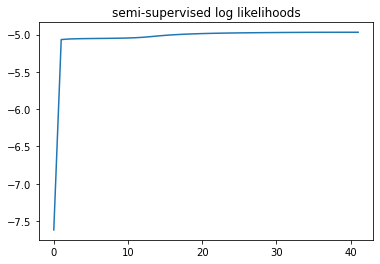

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [178]:
x_unlabeled = r_test_mod[significant_columns].values
x_labeled = X_train[significant_columns].values
y_labeled = y_train["target"].values
learned_params = learn_params(x_labeled, y_labeled)
(
    semisupervised_forecasts,
    semisupervised_posterior,
    semisupervised_loglikelihoods,
) = run_em(x_unlabeled, learned_params)
print("total steps: ", len(semisupervised_loglikelihoods))
plt.plot(semisupervised_loglikelihoods)
plt.title("semi-supervised log likelihoods")
# plt.savefig("semi-supervised.png")

In [186]:
y_pred = semisupervised_posterior[:, 1]

# Convert y_pred array to pandas dataframe
pred_test = pd.DataFrame(
    data=y_pred,
    columns=["prediction_ssl_cont"],
    index=dfr_test_with_label_X.index.copy(),
)

# Set quantile
q = pred_test["prediction_ssl_cont"].quantile(q=1 - conservative_dr)
pred_test["prediction_ssl"] = pred_test["prediction_ssl_cont"].apply(
    lambda x: 0 if (x < q) else 1
)

# Merge Baseline and SSL prediction
pred_test_final2 = pd.merge(
    outcome_b[["target", "prediction_baseline", "prediction_beforeRI_binary"]],
    pred_test[["prediction_ssl"]],
    how="inner",
    left_index=True,
    right_index=True,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [187]:
pred_test_final2

,target,prediction_baseline,prediction_beforeRI_binary,prediction_ssl
18096,1,0,0,1
10838,0,0,0,0
15233,1,1,1,1
15997,0,0,0,0
18772,0,0,0,0
...,...,...,...,...
12694,0,0,0,1
17324,1,0,0,0
17428,0,0,0,0
17995,0,0,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [188]:
pred_test_final2["Flag"] = pred_test_final2.apply(flag_df_ssl, axis=1)
kickout_ssl(pred_test_final2)

Kickout + Kickin Metric: -0.052


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>